# Index
- [import election dataset](#import-election-dataset)   
- [import US states geometry](#import-US-state-maps)
- [state-level election map](#State-level-election-map) 
    * [Cartogram: population]( #cartogram-of-state-level-map)
    * [Cartogram: electoral college](#cartogram-with-electoral-college)
- [county-level election map](#county-level-election-map)
    * [Cartogram at county level](#county-level-cartogram)
- [state-level cartograms](#state-level-cartogram,-with-highways)

### workspace setup and definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os, json, csv
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
from joblib import Parallel, delayed

import basemap from mpl_toolkits. The first two commented lines were necessary in my WSL (Linux on Windows) standard installation, but are not needed in the conda environment setup

In [2]:
# import mpl_toolkits
# mpl_toolkits.__path__.append('/usr/local/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap
# define standard US projection map once for all (Albers equal area)
themap = Basemap(llcrnrlon=-130,llcrnrlat=24,urcrnrlon=-65,urcrnrlat=50, epsg=2163)

In [3]:
# global setting for including watermarks in plots
wm = True

In [4]:
def col_alpha_rescale(percentD,percentR, scale=0.4):
    """ Return RGBA color according to D, R vote percents, namely blue if D>R and red otherwise, 
    with transparency A set by vote difference fully opaque colors at and above input parameter scale (default=0.4)"""
    red, blue = (0., 1.) if percentD > percentR else (1.,0.)
    alpha = min(max(0.2 + 0.8*(np.abs(percentD-percentR)/(scale)),0),1)
    return  (red, 0, blue,alpha)

In [5]:
def func_add_legend(fig, left=1.05, width=0.015, height=0.7, voffset=0):
    """Add red/blue bar legend to a figure, with offset position given as input"""
    cax = fig.add_axes([left, (1.-height)/2, width, height])
    for cc in np.arange(0.8,0.49,-0.1):
        _=cax.fill((0,0,1,1),(cc,cc+0.1,cc+0.1,cc),facecolor = col_alpha_rescale((1-cc)/2,cc/2) )
        _=cax.plot((0,1),(cc,cc),lw=1,c='w' )
    for cc in np.arange(0.2,0.51,0.1):
        _=cax.fill((0,0,1,1),(cc-0.1,cc,cc,cc-0.1),facecolor = col_alpha_rescale((1-cc)/2+0.01,cc/2) )
        _=cax.plot((0,1),(cc,cc),lw=1,c='w' )
    ax2=cax.twiny()    
    cax.yaxis.tick_right()
    cax.set_yticks(np.arange(0.2,0.81,0.1))
    _= cax.set_yticklabels(map(str,range(30,1,-10)+range(0,31,10)))
    for ax in [cax,ax2]:
        _=ax.set_xticks([])
    _=cax.set_ylim([0.15,0.85])
    _=cax.set_xlabel('D margin (%)')
    _=ax2.set_xlabel('R margin (%)')
    return fig

In [6]:
def millify(n, millnames = ['n','u','m','','k','M','B','T']):
    i_zero = millnames.index('')
    n = float(n)
    millidx = max(0,i_zero+min(len(millnames)-1,  int(np.floor(0 if n == 0 else np.log10(abs(n))/3))))
    strformat = '{:.1f}{}' if i_zero==0 and n<1 else '{:.0f}{}'
    return strformat.format(n / 10**(3 * (millidx-i_zero)), millnames[millidx])
# for n in (1.23456789 * 10**r for r in range(-9, 13, 1)):
#     print('%25.9f: %20s' % (n,millify(n)))

# import election dataset
[link to the top](#Index)

The election results are downloaded from [OpenDataSoft](http://data.opendatasoft.com/explore/dataset/usa-2016-presidential-election-by-county@public/), which repackaged data first created on GitHub by [Deleetdk](https://github.com/Deleetdk/USA.county.data), which in turns scraped the NY Times website.

The dataset is not perfect: First, county data for Alaska is not included (we will fix this by using another source). Second, the totals for each party miss 1-3 millions votes (when compared to the [NYT final counts](https://www.nytimes.com/elections/results/president)). The dataset is probably missing provisional or mail-in ballots?

In [7]:
with open(os.path.join('input','usa-2016-presidential-election-by-county.json')) as f:
    data = json.load(f)

Content of the dictionary just imported:

In [12]:
print data[0].keys()
print sorted(data[0]['fields'].keys())

[u'recordid', u'fields', u'record_timestamp', u'geometry', u'datasetid']
[u'acfs', u'adult_obesity', u'adult_smoking', u'adults_65_and_older_living_in_poverty', u'african_american_population', u'amerindian', u'annual_prcp', u'annual_tavg', u'annual_tmax', u'annual_tmin', u'asian', u'asian_american_population', u'at_least_bachelor_s_degree', u'at_least_high_school_diploma', u'autumn_prcp', u'autumn_tavg', u'autumn_tmax', u'autumn_tmin', u'black', u'ca', u'cfs', u'child_poverty_living_in_families_below_the_poverty_line', u'children_in_single_parent_households', u'children_under_6_living_in_poverty', u'construction_extraction_maintenance_and_repair_occupations', u'county', u'dem08', u'dem08_frac', u'dem08_frac2', u'dem12', u'dem12_frac', u'dem12_frac2', u'dem16_frac', u'dem16_frac2', u'diabetes', u'elevation', u'elevation_bins', u'est_votes_remaining', u'farming_fishing_and_forestry_occupations', u'fips', u'geo_shape', u'gini_coefficient', u'graduate_degree', u'green16_frac', u'hispanic',

Apart from Alaska, a couple of entries need fixing: Shannon county, SD does not have vote data, and Bedford City, Virginia does not have a `'st'` entry (short state, e.g. VA. Those are fixed by hand

In [8]:
for idx in [3074]:
    data[idx]['fields']['votes']= 2857
    data[idx]['fields']['votes16_clintonh']= 2510
    data[idx]['fields']['votes16_trumpd']= 241
    data[idx]['fields']['votes16_steinj']= 0
    data[idx]['fields']['votes16_johnsong']= 106 
    data[idx]['fields']['total08']= 3712
    data[idx]['fields']['dem08_frac']= 100.*1637/3712
    data[idx]['fields']['rep08_frac']= 100.*2075/3712
    data[idx]['fields']['total12']= 3692
    data[idx]['fields']['dem12_frac']= 100.*1302/3692
    data[idx]['fields']['rep12_frac']= 100.*2262/3692
data[3117]['fields']['st']=u'VA'

In [9]:
n_counties = len(data)
good_counties0 = [idx for idx in range(n_counties) if 'votes' in data[idx]['fields']]
print 'Counties with election result data: %1d/%2d' %(len(good_counties0),n_counties)
print 'Missing information from following states:', list(set([data[idx]['fields']['st'] for idx in range(n_counties) if idx not in good_counties0]))

Counties with election result data: 3112/3143
Missing information from following states: [u'VA', u'AK', u'HI']


In [10]:
name_counties = [data[idx]['fields']['county'] for idx in range(n_counties)]
# states (long form)
states = sorted(list(set([name.split(',')[1].strip() for name in name_counties])))
# states (short form, but sorted according to long form)
states_short = set( [(data[idx]['fields']['state'],data[idx]['fields']['st']) for idx in range(n_counties)])
states_short = [x[1] for x in sorted(states_short, key = lambda x: x[0])]

In [11]:
counties_by_state = {}
for st in states:
    counties_by_state[st] = [name.split(',')[0] for name in name_counties if name.split(',')[1].strip()==st]

### Aside: import Alaska election results

Alaska does not report its results by county (or borough), but by precint and house district. Fortunately, at https://rrhelections.com/index.php/2018/02/02/alaska-results-by-county-equivalent-1960-2016/ they repackaged the data into county-level data. I downloaded the zip file they make available and exported separate 2008-2016 sheets to csv to import. Then I picked the columns with the needed data (county-equivalent voters can be non-integer because absentee and early votes are only reported by house district and at the link above they split them to each county). Overall, the total voting numbers agree with the state-level ones by the NYT.

I will sort the dataframe in alphabetical order by county name, which gives a list in the same order as the county names imported previously, so I can easily fill the data dictionary I already have. I will also only pick up the column relative to the major party candidates (DRLG) that the rest of the dataset already includes.

In [12]:
akdf = pd.read_csv(os.path.join('input','Alaska2016.csv'))
akdf = akdf.drop([len(akdf)-1]).sort_values('ED/Muni')
akdf = akdf.reset_index(drop=True )
akdf = akdf[['ED/Muni','SL Total','TotPCT Trump,N,19,10','TotPCT Clinton,N,19,10','TotPCT Johnson,N,19,10','TotPCT Stein,N,19,10']]
akdf.head()

ED/Muni       SL Total  TotPCT Trump,N,19,10  \
0  Aleutians East     529.293851              0.504862   
1  Aleutians West    1213.502975              0.345034   
2       Anchorage  130040.329870              0.469720   
3          Bethel    4892.232820              0.224121   
4     Bristol Bay     453.270615              0.527892   

   TotPCT Clinton,N,19,10  TotPCT Johnson,N,19,10  TotPCT Stein,N,19,10  
0                0.364521                0.053393              0.018868  
1                0.542177                0.041152              0.014466  
2                0.415018                0.061300              0.015238  
3                0.547759                0.051809              0.052628  
4                0.354327                0.064143              0.012578

In [13]:
akdf12 = pd.read_csv(os.path.join('input','Alaska2012.csv'))
akdf12 = akdf12.drop([len(akdf12)-1]).sort_values('ED/Muni')
akdf12 = akdf12.reset_index(drop=True )
akdf12 = akdf12[['ED/Muni','SL Total','SLTotPCT Romney,N,19,10','SLTotPCT Obama,N,19,10']]
akdf12.head()

akdf08 = pd.read_csv(os.path.join('input','Alaska2008.csv'))
akdf08 = akdf08.drop([len(akdf08)-1]).sort_values('Municipality')
akdf08 = akdf08.reset_index(drop=True )
akdf08 = akdf08[['Municipality','SL Total Voters','SL PCT McCain','SL PCT Obama']]
akdf08.head()

Municipality  SL Total Voters  SL PCT McCain  SL PCT Obama
0  Aleutians East       675.657819       0.637527      0.328156
1  Aleutians West      1378.234276       0.516135      0.452303
2       Anchorage    135069.651015       0.568453      0.409005
3          Bethel      5173.161937       0.436391      0.519662
4     Bristol Bay       523.567513       0.666527      0.303928

In [14]:
idx_ak = [(data[idx]['fields']['county'],idx) for idx in range(n_counties) if data[idx]['fields']['st']=='AK']
idx_ak = [ [x[1], x[0].split(',')[0]] for x in sorted(idx_ak)]

Verify that the Alaska boroughs are in the same order in the dataframe and the county list from main database

In [20]:
for ii in range(len(sorted(counties_by_state['Alaska']))):
    if not sorted(counties_by_state['Alaska'])[ii].startswith(akdf['ED/Muni'].tolist()[ii]):
        print sorted(counties_by_state['Alaska'])[ii],' --', (akdf['ED/Muni'].tolist()[ii])
    if not sorted(counties_by_state['Alaska'])[ii].startswith(akdf12['ED/Muni'].tolist()[ii]):
        print sorted(counties_by_state['Alaska'])[ii],' --', (akdf12['ED/Muni'].tolist()[ii])
    if not sorted(counties_by_state['Alaska'])[ii].startswith(akdf08['Municipality'].tolist()[ii]):
        print sorted(counties_by_state['Alaska'])[ii],' --', (akdf08['Municipality'].tolist()[ii])

In [15]:
for ii, idx in enumerate(idx_ak):
    data[idx[0]]['fields']['votes'] = int(akdf.iloc[[ii]]['SL Total'].tolist()[0])
    data[idx[0]]['fields']['votes16_trumpd'] = int(akdf.iloc[[ii]]['TotPCT Trump,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['votes16_clintonh'] = int(akdf.iloc[[ii]]['TotPCT Clinton,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['votes16_steinj'] = int(akdf.iloc[[ii]]['TotPCT Johnson,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['votes16_johnsong'] = int(akdf.iloc[[ii]]['TotPCT Stein,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['dem12_frac'] = 100.*akdf12.iloc[[ii]]['SLTotPCT Obama,N,19,10'].tolist()[0]
    data[idx[0]]['fields']['rep12_frac'] = 100.*akdf12.iloc[[ii]]['SLTotPCT Romney,N,19,10'].tolist()[0]
    data[idx[0]]['fields']['total12'] = int(akdf12.iloc[[ii]]['SL Total'].tolist()[0])
    data[idx[0]]['fields']['dem08_frac'] = 100.*akdf08.iloc[[ii]]['SL PCT Obama'].tolist()[0]
    data[idx[0]]['fields']['rep08_frac'] = 100.*akdf08.iloc[[ii]]['SL PCT McCain'].tolist()[0]
    data[idx[0]]['fields']['total08'] = int(akdf08.iloc[[ii]]['SL Total Voters'].tolist()[0])

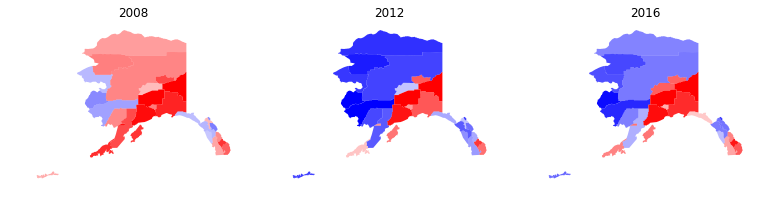

In [22]:
fig, axes = plt.subplots(1,3,figsize=(13,3))
for idx in idx_ak:
    try: border = data[idx[0]]['fields']['geo_shape']['coordinates']
    except: print idx; continue
    if len(border)>1:
        try: main_pol = max( border, key= lambda x: Polygon(x[0]).area)[0]
        except: main_pol = max( border, key= lambda x: Polygon(x).area)
    else: main_pol = border[0]

    red = 1.*data[idx[0]]['fields']['rep08_frac']/100.
    blue = 1.*data[idx[0]]['fields']['dem08_frac']/100.
    axes[0].fill(*np.array(main_pol).T, facecolor=col_alpha_rescale(blue, red))
    red = 1.*data[idx[0]]['fields']['rep12_frac']/100.
    blue = 1.*data[idx[0]]['fields']['dem12_frac']/100.
    axes[1].fill(*np.array(main_pol).T, facecolor=col_alpha_rescale(blue, red))
    red = 1.*data[idx[0]]['fields']['votes16_trumpd']/data[idx[0]]['fields']['votes']
    blue = 1.*data[idx[0]]['fields']['votes16_clintonh']/data[idx[0]]['fields']['votes']
    axes[2].fill(*np.array(main_pol).T, facecolor=col_alpha_rescale(blue, red))
for ax in axes: ax.set_axis_off()
for ii in range(3): axes[ii].set_title(['2008','2012','2016'][ii]);

In [23]:
[(idx[1], data[idx[0]]['fields']['rep12_frac']) for idx in idx_ak]

[(u'Aleutians East Borough', 48.6649645580677),
 (u'Aleutians West Census Area', 34.575184091239194),
 (u'Anchorage Municipality', 53.0445332155861),
 (u'Bethel Census Area', 25.550405081555898),
 (u'Bristol Bay Borough', 52.4876810136766),
 (u'Denali Borough', 46.604282884900606),
 (u'Dillingham Census Area', 34.5367544743603),
 (u'Fairbanks North Star Borough', 58.56641975892071),
 (u'Haines Borough', 45.813004495915706),
 (u'Hoonah-Angoon Census Area', 36.5968879460447),
 (u'Juneau City and Borough', 38.5749133675913),
 (u'Kenai Peninsula Borough', 65.9749566834281),
 (u'Ketchikan Gateway Borough', 55.9556736295157),
 (u'Kodiak Island Borough', 56.3619053039085),
 (u'Lake and Peninsula Borough', 36.4497150085573),
 (u'Matanuska-Susitna Borough', 71.27965336736791),
 (u'Nome Census Area', 32.6374596582191),
 (u'North Slope Borough', 32.73403391778211),
 (u'Northwest Arctic Borough', 30.7717011144731),
 (u'Petersburg Census Area', 44.122834636970296),
 (u'Prince of Wales-Hyder Census 

## consolidate state-level data 

In [16]:
good_counties = [idx for idx in range(n_counties) if 'votes' in data[idx]['fields']]
bad_counties = [idx for idx in range(n_counties) if 'votes' not in data[idx]['fields']]
len(states), len(states_short)
len(good_counties), len(name_counties)

(3141, 3143)

The remaining missing counties are Kalawao County, Hawaii, and Bedford city, Virginia. The former has 139 inhabitants and only [20 votes cast in the last election](https://en.wikipedia.org/wiki/United_States_presidential_election_in_Hawaii,_2016#Results_by_county), so I will neglect it, while the latter is a mistake as it is not a county, but a city. The surrounding county, Bedford County, VA, is `data[1083]`. Therefore we drop both and will only work with the remaining 3141 counties.

We now make a state-level dictionary with votes and population information

In [17]:
dictionary = {}
for st in states_short:
    dictionary[st]={}
    dictionary[st]['votes'] = sum([ data[idx]['fields']['votes'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['total_population'] = sum([ data[idx]['fields']['total_population'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['D'] = sum([ data[idx]['fields']['votes16_clintonh'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['R'] = sum([ data[idx]['fields']['votes16_trumpd'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['G'] = sum([ data[idx]['fields']['votes16_steinj'] for idx in good_counties if data[idx]['fields']['st']==st and 'votes16_steinj' in data[idx]['fields']])
    dictionary[st]['L'] = sum([ data[idx]['fields']['votes16_johnsong'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['votes08'] = sum([ data[idx]['fields']['total08'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['votes12'] = sum([ data[idx]['fields']['total12'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['D08'] = sum([ data[idx]['fields']['dem08_frac']/100*data[idx]['fields']['total08'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['R08'] = sum([ data[idx]['fields']['rep08_frac']/100*data[idx]['fields']['total08'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['D12'] = sum([ data[idx]['fields']['dem12_frac']/100*data[idx]['fields']['total12'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['R12'] = sum([ data[idx]['fields']['rep12_frac']/100*data[idx]['fields']['total12'] for idx in good_counties if data[idx]['fields']['st']==st])

In [18]:
# nationwide
for kk in dictionary[states_short[0]].keys():
    dictionary[kk]=sum([dictionary[st][kk] for st in states_short])

print "(total 2016 votes, D, R, D fraction)= %1d, %2d, %3d, %1.4g" %(dictionary['votes'],dictionary['D'],dictionary['R'],1.*dictionary['D']/dictionary['votes'])
print "(total 2012 votes, D, R, D fraction)= %1d, %2d, %3d, %1.4g" % (dictionary['votes12'],dictionary['D12'],dictionary['R12'],1.*dictionary['D12']/dictionary['votes12'])
print "(total 2018 votes, D, R, D fraction)= %1d, %2d, %3d, %1.4g" % (dictionary['votes08'],dictionary['D08'],dictionary['R08'],1.*dictionary['D08']/dictionary['votes08'])

(total 2016 votes, D, R, D fraction)= 130252582, 62544895, 61228169, 0.4802
(total 2012 votes, D, R, D fraction)= 129084477, 65903853, 60931728, 0.5105
(total 2018 votes, D, R, D fraction)= 131301281, 69496210, 59950425, 0.5293


# import US state maps
[link to the top](#Index)

We download the maps from the US census website. **NB ADD DETAILS AND LINKS!!!!!**
We actually download two different datasets, the second one with more accurate state borders.

In [19]:
us_df = gpd.GeoDataFrame.from_file(os.path.join('input',"State_2010Census_DP1.dbf"))
us_df = us_df.sort_values('NAME10')
us_df = us_df.reset_index(drop=True )
us_df.head()

GEOID10 STUSPS10      NAME10       ALAND10      AWATER10   INTPTLAT10  \
0      01       AL     Alabama  1.311708e+11  4.596558e+09  +32.7396323   
1      02       AK      Alaska  1.477953e+12  2.453835e+11  +63.3461910   
2      04       AZ     Arizona  2.942073e+11  1.026196e+09  +34.2099643   
3      05       AR    Arkansas  1.347713e+11  2.960539e+09  +34.8955256   
4      06       CA  California  4.034663e+11  2.050111e+10  +37.1485730   

     INTPTLON10  DP0010001  DP0010002  DP0010003    ...     DP0210001  \
0  -086.8434593    4779736     304957     308229    ...       1883791   
1  -152.8370679     710231      53996      50887    ...        258058   
2  -111.6024010    6392017     455715     453680    ...       2380990   
3  -092.4446262    2915918     197689     196877    ...       1147084   
4  -119.5406515   37253956    2531333    2505839    ...      12577498   

   DP0210002  DP0210003  DP0220001  DP0220002  DP0230001  DP0230002  \
0    1312589     571202    3311304    1352616       2.52       2.37   
1     162765      95293     448438     235441       2.76       2.47   
2    1571687     809303    4134117    2118516       2.63       2.62   
3     768156     378928    1929218     907769       2.51       2.40   
4    7035371    5542127   20742929   15691211       2.95       2.83   

   Shape_Leng  Shape_Area  geometry  
0   17.345067   13.067232      None  
1  252.035803  313.995134      None  
2   23.927353   28.919122      None  
3   22.096614   13.585384      None  
4   42.618086   43.083360      None  

[5 rows x 196 columns]

In [20]:
us_df1 = gpd.read_file(os.path.join('input','cb_2017_us_state_20m.shp'))
us_df1 = us_df1.sort_values('NAME')
us_df1 = us_df1.reset_index(drop=True )
us_df1.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD          ALAND  \
0      01  01779775  0400000US01    01     AL     Alabama   00   131174431216   
1      02  01785533  0400000US02    02     AK      Alaska   00  1478588231566   
2      04  01779777  0400000US04    04     AZ     Arizona   00   294198661567   
3      05  00068085  0400000US05    05     AR    Arkansas   00   134768100673   
4      06  01779778  0400000US06    06     CA  California   00   403483182192   

         AWATER                                           geometry  
0    4592944701  POLYGON ((-88.46866248405129 31.8938557116156,...  
1  277723861311  (POLYGON ((-173.074642 60.704657, -172.912636 ...  
2    1027245114  POLYGON ((-114.799683 32.593621, -114.809393 3...  
3    2963631791  POLYGON ((-94.617919 36.499414, -94.3612029999...  
4   20484637928  (POLYGON ((-118.593969 33.467198, -118.484785 ...

We now replace state geometries in main dataframe with more accurate ones:

In [21]:
us_df['geometry'] = us_df1['geometry']
us_df.crs = us_df1.crs

Define lower 48 states (with DC). Aside from Puerto Rico (can't vote), Hawaii and Alaska will be added by hand on the side of the plots.

In [22]:
cdf = us_df.loc[~us_df['NAME10'].isin( ['Hawaii', 'Alaska','Puerto Rico'])]

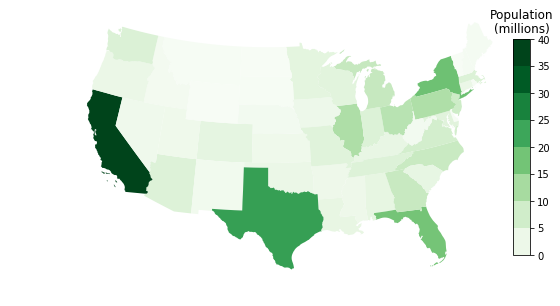

In [23]:
states_map = cdf.to_crs(epsg=2163)
fig, ax = plt.subplots(figsize=(8, 5))
_=states_map.plot(ax=ax,column='DP0010001',cmap='Greens')
_=ax.axis('off')

# add legendbar
cax = fig.add_axes([0.9, 0.2, 0.03, 0.6])
bounds = np.arange(0,41,5)
cb = mpl.colorbar.ColorbarBase(cax,cmap='Greens', norm=mpl.colors.Normalize(vmin=0, vmax=35), 
                               ticks=bounds, boundaries=bounds)
_=cb.ax.set_title('Population\n(millions)')

In [24]:
state_short_to_long = {}
state_long_to_short = {}
for pair in np.array([us_df['NAME10'].tolist(),us_df['STUSPS10'].tolist()]).T:
    state_short_to_long[pair[1]] = pair[0]
    state_long_to_short[pair[0]] = pair[1]

Identify main border of each state by the one with largest area (except for Hawaii, where I add all the main islands) (here area is computed in square degrees, not in m2 as the comparison will hold in each state). For Alaska, Hawaii, shift the borders to bottom left of continental US. Becaus AK is huge, we scale it down by 0.4


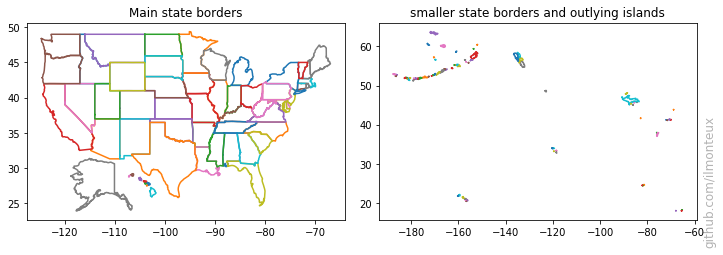

In [25]:
state_border = {}
minor_borders = {}
fig, axes = plt.subplots(1,2,figsize=(10,3.5))
for st,borders in us_df[['STUSPS10','geometry']].itertuples(index=False):
    poly = []
    if borders.geom_type == 'MultiPolygon':
        for pol in borders:
            poly.append(pol)
    else:
        poly.append(borders)
    main_pol = max( poly, key= lambda x: x.area)
    if st=='AK': state_border[st] = np.array(map(lambda (x,y): [0.32*x-65,0.44*y], np.array(main_pol.exterior.coords.xy).T)).T
    elif st=='HI':
        hawaii_keys = []
        for ip, pol in enumerate(borders):
            hawaii_keys.append(st+str(ip))
            state_border[st+str(ip)] = list(np.array(map(lambda (x,y): [x+53,y+7], np.array(pol.exterior.coords.xy).T )).T)
    else: state_border[st] = main_pol.exterior.coords.xy
    minor_borders[st] = []
    for pol in poly:
        if pol != main_pol: minor_borders[st].append(pol.exterior.coords.xy)
    for pol in minor_borders[st]:
        axes[1].plot(np.mod(pol[0],-360),pol[1]) # keep togethere AK smaller islands that go around date change line

for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    axes[0].plot(*state_border[st])
axes[0].set_title('Main state borders')
axes[1].set_title('smaller state borders and outlying islands');
if wm: fig.text(1, 0., 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
fig.tight_layout()
fig.savefig('figs/states_main_minor.png');

Finally, add back Michigan's Upper Peninsula to Michigan's state borders. Here by simplicty we connect by hand along the [Strait of Mackinac](https://en.wikipedia.org/wiki/Straits_of_Mackinac).

In [26]:
# find closest coordinate pairs between main MI and upper MI
closest = sorted([[p1,p2, (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 ]  for p1 in np.array(state_border['MI']).T for p2 in np.array(minor_borders['MI'][4]).T], key =lambda x: x[-1])[0]
x0=np.where(np.array(state_border['MI']).T == closest[0])[0][0]
x1=np.where(np.array(minor_borders['MI'][4]).T == closest[1])[0][0]
# reorder the coordinates
cc1 = np.array(map(lambda x: np.roll(x, -x0),state_border['MI'])).T
cc2 = np.array(map(lambda x: np.roll(x, -x1),minor_borders['MI'][4])).T
aa=np.concatenate([cc1,cc2]).T
# redefine MI border with both pieces
state_border['MI'] = aa[0],aa[1]

# State level election map
[link to the top](#Index)

The goal is to make a plot like the New York Times, e.g. https://www.nytimes.com/elections/results/president

Colors: this is simple because a color in RGB is simply specified as (R, G, B), where the numbers are between 0 and 1. We will color a state blue/red if it has a D/R plurality of votes, with the intensity (alpha channel) of the color proportional to the level of D/R split.

In [27]:
state_colors={}
state_colors12, state_colors08 = {},{}

for st in states_short:
    state_colors[st]= col_alpha_rescale(1.0*dictionary[st]['D']/dictionary[st]['votes'],1.0*dictionary[st]['R']/dictionary[st]['votes'])
    state_colors12[st]= col_alpha_rescale(1.0*dictionary[st]['D12']/dictionary[st]['votes12'],1.0*dictionary[st]['R12']/dictionary[st]['votes12'])
    state_colors08[st]= col_alpha_rescale(1.0*dictionary[st]['D08']/dictionary[st]['votes08'],1.0*dictionary[st]['R08']/dictionary[st]['votes08'])
for st in hawaii_keys:
    state_colors[st]=state_colors['HI']
    state_colors12[st]=state_colors12['HI']
    state_colors08[st]=state_colors08['HI']

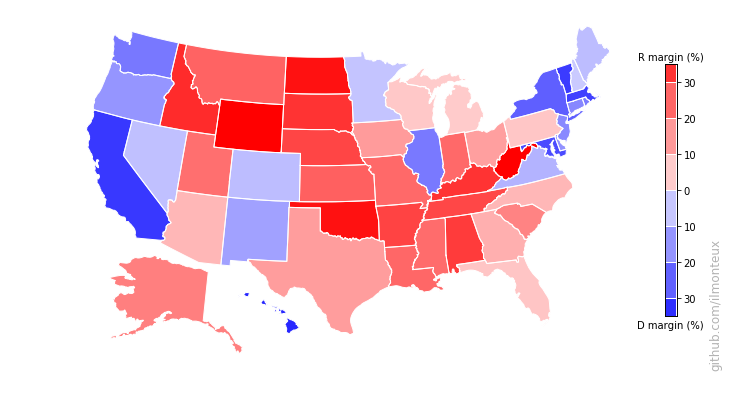

In [28]:
figst0, ax = plt.subplots(figsize=(8,5))
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    ax.plot(*themap(*state_border[st]),c='w',lw=1)
    ax.fill(*themap(*state_border[st]),facecolor=state_colors[st])

ax.set_axis_off()
# add legend
figst0.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figst0.text(1.15, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figst0 = func_add_legend(figst0, width=0.02);

Same, but compare 2008-2016 results

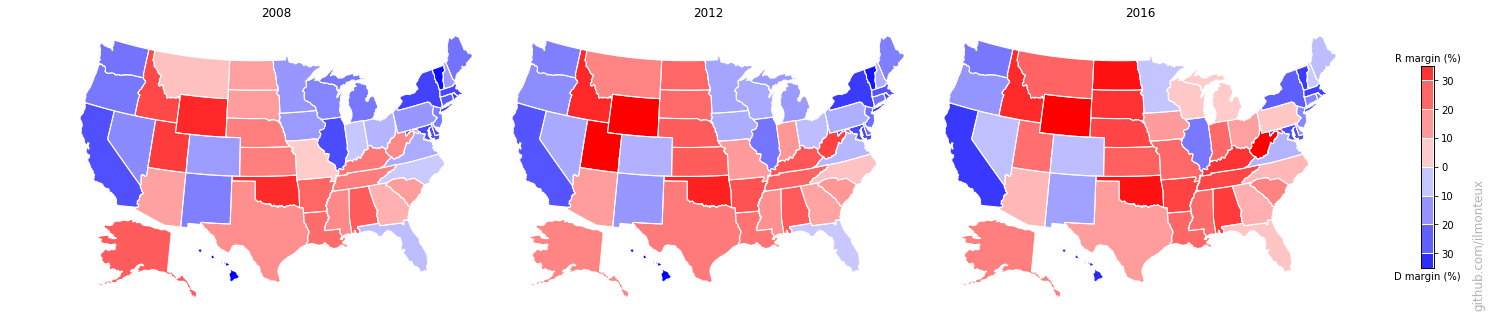

In [38]:
figst1, axes = plt.subplots(1,3,figsize=(18,4))
for ix, ax in enumerate(axes):
    for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
        ax.plot(*themap(*state_border[st]),c='w',lw=1)
        ax.fill(*themap(*state_border[st]),facecolor=[state_colors08[st],state_colors12[st],state_colors[st]][ix])

    ax.set_axis_off()
    ax.set_title(['2008','2012','2016'][ix])
# add legend
figst1.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figst1.text(1.1, 0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figst1 = func_add_legend(figst1, width=0.01);

In [121]:
figst0.savefig('figs/election_state_map16.png', bbox_inches='tight',dpi=120)
figst1.savefig('figs/election_state_map081216.png', bbox_inches='tight',dpi=120)

## cartogram of state-level map

More populous states account for more votes. One can reshape the map to take that into account.  
I will use the diffusion based algorithm of Gastner and Newmann [(link to paper)](www.pnas.org/content/101/20/7499), in particular using the C++ implementation provided by one of the authors at http://www-personal.umich.edu/~mejn/cart/. After downloading and compiling it, in my setup the executable is in a subfolder of the parent directory, `cart-1.2.2`.

The program works by creating a rectangular $n_x\times n_y$ grid of the quantity that we want to equalize across the map: in this case we want each state area to reflect the population, that is, after creating the cartogram, the **population density** will be the same, as more populous states have increased in size at the expense of less populated ones.   
After running the program `cart`, the output is a shifted grid, where each point of the original $n_x\times n_y$ grid is shifted to equalize the population density.   
To make things a little more complicated, the program does not work in the original latitude/longitude coordinates, but in grid coordinates (that is $x,y$ go from 0 to $n_x, n_y$). So for each point (e.g. a state or county border), we have to map the physical coordinates to grid coordinates, and then interpolate in between the grid coordinates output. Below we define functions that do exactly that.

In [29]:
path_to_cart = '../cart-1.2.2/'
!cd $path_to_cart; pwd

/media/angelo/dataHD/DataScience/cart-1.2.2


In [30]:
def cartogrid_remap(cartogrid, x1, y1):
    """ Given an nx*ny grid of (x,y) points used for the cartogram, remap the point (x1,y1) into index coordinates,
    for example grid[0][0]->[0,0], grid[-1][-1]->[nx,ny]
    """
    x0, y0 = cartogrid[0][0]
    x2, y2 = cartogrid[-1][-1]
    dx, dy = (x2-x0)/len(cartogrid[0]), (y2-y0)/len(cartogrid)

    return [(x1-x0)/dx, (y1-y0)/dy]

def interp_cartogram(cartogrid, gridx, gridy, point):
    """ Bilinear interpolation based on cartogram output """
    x1, y1 = cartogrid_remap(cartogrid, point[0], point[1])
    
    ix1, iy1 = int(np.floor(x1)), int(np.floor(y1))

    # nearest neighbor interpolation
    #xout, yout = gridx[ix1,iy1], gridy[ix1,iy1]
    #grids have ny+1, nx+1 shape
    xout, yout = gridx[iy1,ix1], gridy[iy1,ix1]
    # bilinear interpolation
    #xout = np.array([ix1+1-x1, x1-ix1]).dot(np.array([[gridx[ix1,iy1], gridx[ix1,iy1+1]],[gridx[ix1+1,iy1], gridx[ix1+1,iy1+1]]])).dot(np.array([iy1+1-y1, y1-iy1]))
    #yout = np.array([ix1+1-x1, x1-ix1]).dot(np.array([[gridy[ix1,iy1], gridy[ix1,iy1+1]],[gridy[ix1+1,iy1], gridy[ix1+1,iy1+1]]])).dot(np.array([iy1+1-y1, y1-iy1]))
    xout = np.array([ix1+1-x1, x1-ix1]).dot(np.array([[gridx[iy1, ix1], gridx[iy1+1, ix1]],[gridx[iy1,ix1+1], gridx[iy1+1,ix1+1]]])).dot(np.array([iy1+1-y1, y1-iy1]))
    yout = np.array([ix1+1-x1, x1-ix1]).dot(np.array([[gridy[iy1, ix1], gridy[iy1+1, ix1]],[gridy[iy1,ix1+1], gridy[iy1+1,ix1+1]]])).dot(np.array([iy1+1-y1, y1-iy1]))
    return [xout, yout]

In [31]:
def point_from_lat_lon(latlon):
    """Given a (lat,lon) pair, return a shapely.Point() object"""
    return Point(latlon[1],latlon[0]) 

def find_in_state(latlon):
    """Given a (lat,lon) pair, find the state that it is inside (using shapely.Polygon.contains() on all the state borders)"""
    point = point_from_lat_lon(latlon)
    state_flag =[]
    for st in (cdf['STUSPS10'].tolist()+hawaii_keys+['AK']):
        state_flag.append(Polygon(np.array(state_border[st]).T).contains(point))
    return np.array(cdf['STUSPS10'].tolist()+[u'HI' for i in hawaii_keys]+['AK'])[state_flag]

Define function that will run `cart` all in one step

In [32]:
def run_cart(densitygrid, filename):
    """ Run Gastner-Newmann algorightm via the program 'cart', starting from an input 2D density grid 
    (e.g. population density): outputs in folder where 'cart' executable is, executes it, imports
    output and returns shifted x,y grids which can be used to plot any other geographical feature.
    """
    nx, ny = len(densitygrid[0]), len(densitygrid)
    np.savetxt(os.path.join(path_to_cart,filename), densitygrid, fmt="%3.3g")
    # in jupyter, this would be:  !cd $path_to_cart; ./cart $nx $ny  filename.dat  output_filename.dat
    os.system('cd '+path_to_cart+'; ./cart '+str(nx)+' '+str(ny)+'  '+filename+'  output_'+filename)
    cart_output = np.loadtxt(os.path.join(path_to_cart,'output_'+filename))
    cx = cart_output.T[0].reshape(len(densitygrid)+1,len(densitygrid[0])+1)
    cy = cart_output.T[1].reshape(len(densitygrid)+1,len(densitygrid[0])+1)
    return cx, cy

Find population density of each US state (for ease, I translate it to population/square mile). I also need average density, which for the purpose of this plot should be taken with rescaled coordinates for Alaska and Hawaii (in theory, I could take AK/HI true sizes). One can check that the main state border area agrees within a few % with the US census dataframe values.

In [34]:
# (cdf['ALAND10']/[Polygon(np.array(themap(*state_border[st])).T).area for st in (cdf['STUSPS10'].tolist())]).tolist()

In [33]:
# using real state sizes
st_density0 = {}
avg_density0 = 1609.34**2 * float(us_df[['DP0010001']].sum())/ float(us_df[['ALAND10']].sum()) 
tmp = 1609.34**2 *  us_df['DP0010001']/us_df['ALAND10']
for ist, st in enumerate(us_df['STUSPS10'].tolist()):
    st_density0[st] = tmp.tolist()[ist]

# using morphed HI/AK sizes: here I have to use a projection, which will be Albers equal area (epsg=2163)
st_density = {}
avg_density = 1609.34**2 *float(us_df[['DP0010001']].sum())/ float(sum([Polygon(np.array(themap(*state_border[st])).T).area for st in (cdf['STUSPS10'].tolist()+hawaii_keys+['AK'])]))
for st in (cdf['STUSPS10'].tolist()+['AK']):
     st_density[st] = 1609.34**2 * float(us_df.loc[us_df['STUSPS10']==st]['DP0010001'])/Polygon(np.array(themap(*state_border[st])).T).area
st_density['HI'] = 1609.34**2 * float(us_df.loc[us_df['STUSPS10']=='HI']['DP0010001'])/sum([Polygon(np.array(themap(*state_border[st])).T).area for st in hawaii_keys])

In [34]:
%%time

cartogrid=[]
for y in np.linspace(23,51, 57):
    cartogrid.append( [[x,y] for x in np.linspace(-130,-65, 131)])

densitygrid = []
for line in cartogrid:
    outline = []
    for pp in line:
        st = find_in_state((pp[1],pp[0])) # find_in_state() takes (lat,long) pair, the grid is in (long, lat)
        if len(st)==0: 
            density = avg_density
        else:
            density = st_density[st[0]]
        outline.append(density)
    densitygrid.append(outline)

CPU times: user 3min 33s, sys: 0 ns, total: 3min 33s
Wall time: 3min 33s


Check that the density grid and the remapping from lat/lon coordinates into grid coordinates worked fine, for example, superimpose CA border

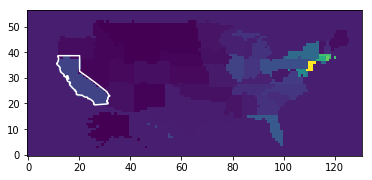

In [35]:
plt.imshow(densitygrid, origin='lower');
plt.plot(*np.array([cartogrid_remap(cartogrid, bb[0], bb[1]) for bb in np.array(state_border['CA']).T ]).T,c='w');

Generate cartogram via executing `cart` and compute shifted state borders from interpolating the cartogram output

In [36]:
cx, cy = run_cart(densitygrid, 'uspop_state.dat')

In [37]:
morphed_border_st={}
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    morphed_border_st[st] = np.array([ interp_cartogram(cartogrid, cx, cy, [bb[0], bb[1]]) for bb in np.array(state_border[st]).T ])

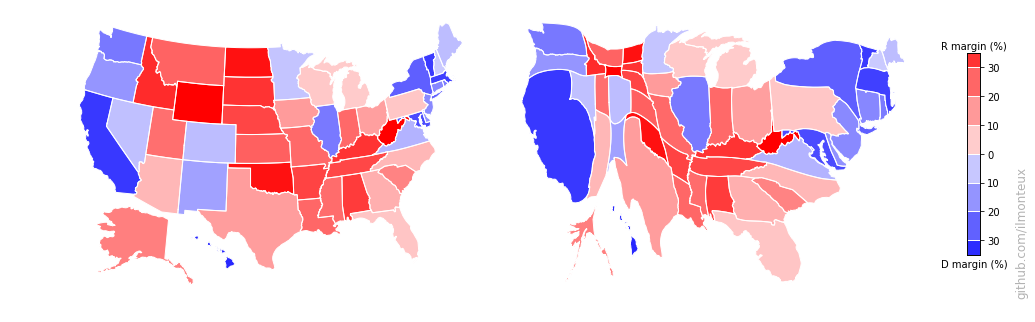

In [49]:
figs0, axes = plt.subplots(1,2,figsize=(12,4))
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    xst, yst = np.array(state_border[st])
    xm,ym = themap(xst,yst)
    axes[0].plot(xm,ym, lw=1, c='w')
    axes[0].fill(xm,ym,facecolor=state_colors[st])
    
    axes[1].plot(*morphed_border_st[st].T, lw=1, c='w')
    axes[1].fill(*morphed_border_st[st].T, facecolor=state_colors[st])
for ax in axes: _=ax.set_axis_off() 
figs0.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
if wm: figs0.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figs0 = func_add_legend(figs0, width=0.015);

Same but comparing 2008-2016 election results. For simplicity, I have not recalculated the cartogram so this does not take into account differences in state populations between 2016 and 2008. (Technically the dataset does not have the total populations for previous years, but they could be retrieved)

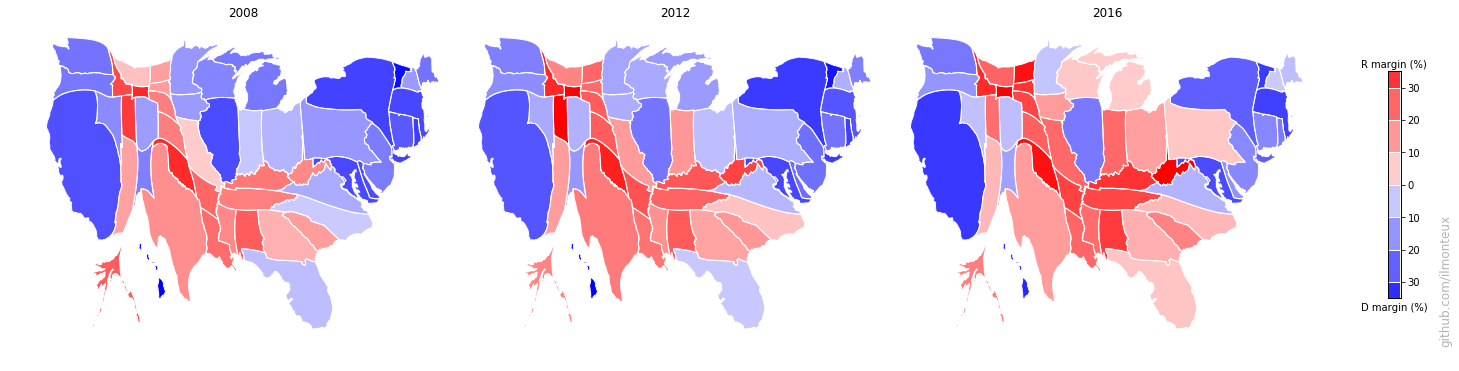

In [50]:
figs1, axes = plt.subplots(1,3,figsize=(18,4.5))
for ix, ax in enumerate(axes):
    for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
        ax.plot(*morphed_border_st[st].T, lw=1, c='w')
        ax.fill(*morphed_border_st[st].T, facecolor=[state_colors08[st],state_colors12[st],state_colors[st]][ix])

    ax.set_axis_off()
    ax.set_title(['2008','2012','2016'][ix])

figs1.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figs1.text(1.1, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figs1 = func_add_legend(figs1, width=0.01);

In [128]:
figs0.savefig('figs/election_state_map_carto16.png', bbox_inches='tight',dpi=120)
figs1.savefig('figs/election_state_carto081216.png', bbox_inches='tight',dpi=120)

# cartogram with electoral college


We will do the same as above, but taking into account electoral college votes instead of population for each state.

In [38]:
ec_dic = {}
with open(os.path.join('input','US-electoral-college-votes.csv')) as f:
    for r in csv.reader(f):
        ec_dic[r[0]]=int(r[1])

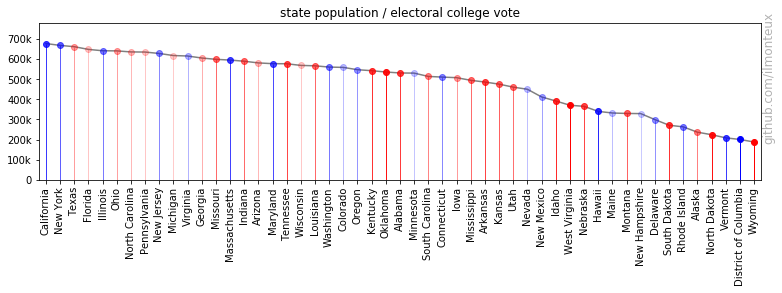

In [39]:
xx = [ [ float(us_df.loc[us_df['NAME10']==st]['DP0010001'])/ec_dic[st], st, us_df.loc[us_df['NAME10']==st]['STUSPS10'].tolist()[0]] for st in ec_dic.keys() ]
fig, ax = plt.subplots(1,1,figsize=(11,4))
ax.plot([x[0] for x in sorted(xx,reverse=True)],c='0.5')
for ix,x in enumerate(sorted(xx,reverse=True)):
    ax.plot(ix,x[0],'o',color=state_colors[x[2]])
    ax.fill([ix,ix],[x[0],0],color=state_colors[x[2]])

plt.xticks(range(len(states_short)),[x[1] for x in sorted(xx,reverse=True)],rotation=90,ha='center')
ax.margins(0.01,0.01)
fig.tight_layout()
if wm: fig.text(1., 0.99, 'github.com/ilmonteux',fontsize=12, ha='right', va='top', rotation=90, alpha=0.3)
ax.set( ylim= (0,.78*10**6), yticks=10**6*np.arange(0,0.79,0.1), yticklabels=map(millify,10**6*np.arange(0,0.79,0.1)), title=('state population / electoral college vote'));

In [40]:
%%time

avg_densityEC = 1609.34**2 *sum(ec_dic.values())/ float(sum([Polygon(np.array(themap(*state_border[st])).T).area for st in (cdf['STUSPS10'].tolist()+hawaii_keys+['AK'])]))

densitygridEC = []
for line in cartogrid:
    outline = []
    for pp in line:
        st = find_in_state((pp[1],pp[0])) # find_in_state() takes (lat,long) pair, the grid is in (long, lat)
        if len(st)==0: 
            density = avg_densityEC
        else:
            if st!=['HI']: density = 1609.34**2 * ec_dic[state_short_to_long[st[0]]]/Polygon(np.array(themap(*state_border[st[0]])).T).area
            else: density = 1609.34**2 * ec_dic['Hawaii']/sum([Polygon(np.array(themap(*state_border[st])).T).area for st in hawaii_keys])            
        outline.append(density)
    densitygridEC.append(outline)

CPU times: user 3min 25s, sys: 0 ns, total: 3min 25s
Wall time: 3min 25s


In [41]:
cx_ec, cy_ec = run_cart(densitygridEC, 'us_elcollege_state.dat')

In [42]:
morphed_border_ec={}
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    morphed_border_ec[st] = np.array([ interp_cartogram(cartogrid, cx_ec, cy_ec, [bb[0], bb[1]]) for bb in np.array(state_border[st]).T ])

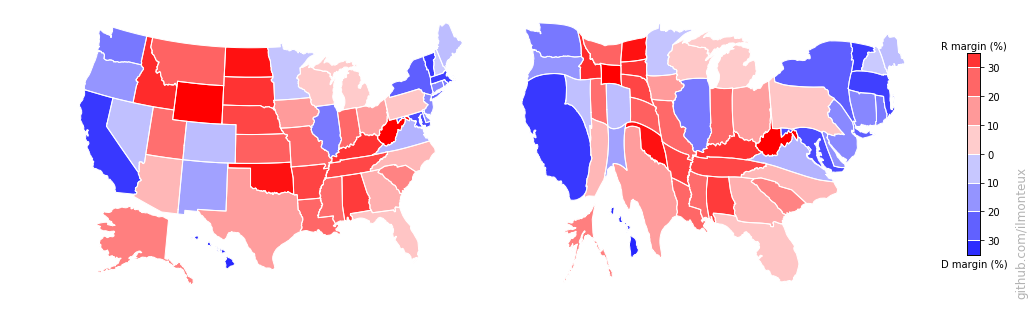

In [59]:
figec0, axes = plt.subplots(1,2,figsize=(12,4))
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    xst, yst = np.array(state_border[st])
    xm,ym = themap(xst,yst)
    axes[0].plot(xm,ym, lw=1, c='w')
    axes[0].fill(xm,ym,facecolor=state_colors[st])
    
    axes[1].plot(*morphed_border_ec[st].T, lw=1, c='w')
    axes[1].fill(*morphed_border_ec[st].T, facecolor=state_colors[st])
for ax in axes: ax.set_axis_off() 

figec0.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
if wm: figec0.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figec0 = func_add_legend(figec0, width=0.015);

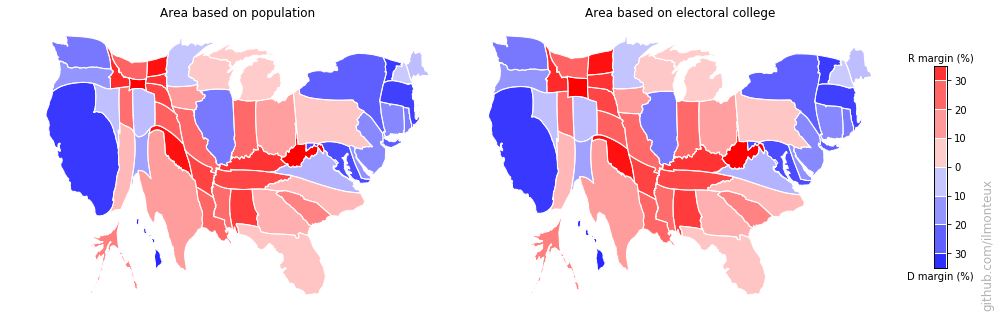

In [60]:
figsec, axes = plt.subplots(1,2,figsize=(12,4))
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    xst, yst = np.array(state_border[st])
    xm,ym = themap(xst,yst)
    axes[0].plot(*morphed_border_st[st].T, lw=1, c='w')
    axes[0].fill(*morphed_border_st[st].T, facecolor=state_colors[st])
    axes[0].set_title('Area based on population')
    axes[1].plot(*morphed_border_ec[st].T, lw=1, c='w')
    axes[1].fill(*morphed_border_ec[st].T, facecolor=state_colors[st])
    axes[1].set_title('Area based on electoral college')
for ax in axes: ax.set_axis_off() 

figsec.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
if wm: figsec.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figsec = func_add_legend(figsec, width=0.015);

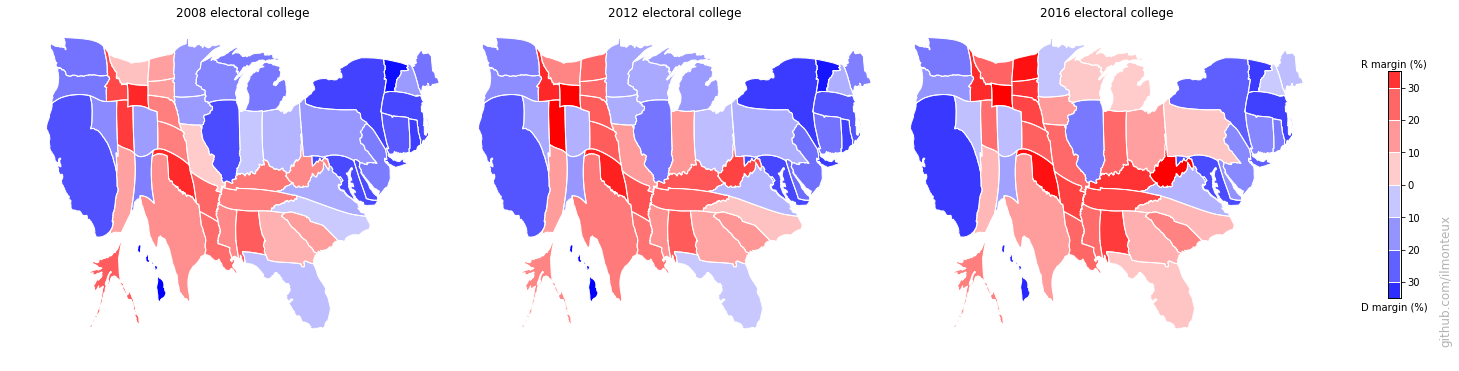

In [61]:
figec1, axes = plt.subplots(1,3,figsize=(18,4.5))
for ix, ax in enumerate(axes):
    for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
        ax.plot(*morphed_border_ec[st].T, lw=1, c='w')
        ax.fill(*morphed_border_ec[st].T, facecolor=[state_colors08[st],state_colors12[st],state_colors[st]][ix])

    ax.set_axis_off()
    ax.set_title(['2008','2012','2016'][ix]+' electoral college')

figec1.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figec1.text(1.1, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figec1 = func_add_legend(figec1, width=0.01);

In [149]:
figec0.savefig('figs/election_state_map_carto16_EC.png', bbox_inches='tight',dpi=120)
figec1.savefig('figs/election_state_carto081216_EC.png', bbox_inches='tight',dpi=120)
figsec.savefig('figs/election_state_pop_EC.png', bbox_inches='tight',dpi=120)

# county-level election map
[link to the top](#Index)

Not all counties in the dataset have geographic information. Will neglect them

In [43]:
counties_borders = {}
for idx in good_counties:
    try: border = data[idx]['fields']['geo_shape']
    except: 
        print "no geo_shape: index = %1d, %2s. Population = %3d" % (idx, data[idx]['fields']['county'], data[idx]['fields']['total_population'])
        continue
    if len(border['coordinates'])>1:
        try: main_pol = max( border['coordinates'], key= lambda x: Polygon(x[0]).area)[0]
        except: main_pol = max( border['coordinates'], key= lambda x: Polygon(x).area)
    else: main_pol = border['coordinates'][0]
    # move Hawaii/Alaska near continental US
    if data[idx]['fields']['st'] == 'HI': main_pol = list(np.array(map(lambda (x,y): [x+53,y+7], main_pol)))
    elif data[idx]['fields']['st'] == 'AK': main_pol = list(np.array(map(lambda (x,y): [0.32*x-65,0.44*y], main_pol)))
    # move Aleutians West below AK
    if idx == 2677: main_pol = list(np.array(map(lambda (x,y): [x+2,y+1], main_pol)))
    counties_borders[idx] = main_pol
print 'County geometry available for %1d/%2d counties...' %( len(counties_borders), len(good_counties))

no geo_shape: index = 21, Pike County, Georgia. Population = 17440
no geo_shape: index = 249, Schley County, Georgia. Population = 4569
no geo_shape: index = 974, Williamsburg city, Virginia. Population = 13199
no geo_shape: index = 1426, Marshall County, Alabama. Population = 90472
no geo_shape: index = 1669, Roane County, Tennessee. Population = 53683
no geo_shape: index = 1680, Washington County, Virginia. Population = 53711
no geo_shape: index = 2385, Terrell County, Georgia. Population = 9839
County geometry available for 3134/3141 counties...


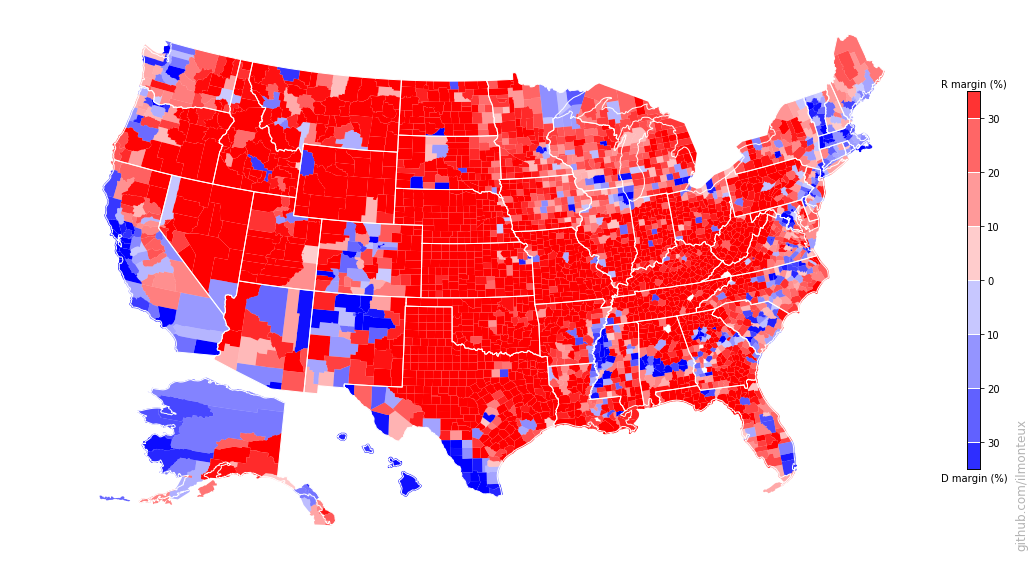

In [63]:
figc0, ax = plt.subplots(1,1,figsize=(12,7.5))
for idx in counties_borders.keys():
    # fill counties with color
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
    ax.fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))

for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    ax.plot(*themap(*state_border[st]), c='w',lw=1)

ax.set_axis_off()
figc0.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figc0.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figc0 = func_add_legend(figc0, width=0.015);

Same map, but with binned vote margins

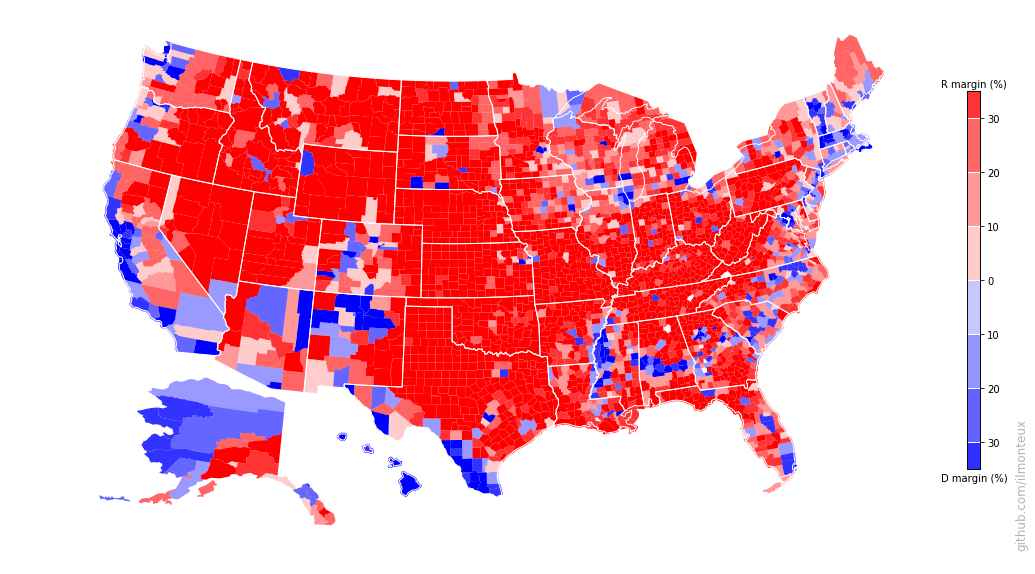

In [64]:
myround = lambda n: n + (0.1 - n) % 0.1

figc1, ax = plt.subplots(1,1,figsize=(12,7.5))
for idx in counties_borders.keys():
    # fill counties with color
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
    red = myround(red)-0.025
    blue = myround(blue)-0.025
    ax.fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))

for st in cdf['STUSPS10'].tolist()+hawaii_keys:
    ax.plot(*themap(*state_border[st]), c='w',lw=1)

ax.set_axis_off()
figc1.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figc1.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figc1 = func_add_legend(figc1, width=0.015);

compare 2008-2016 data, but at the county level

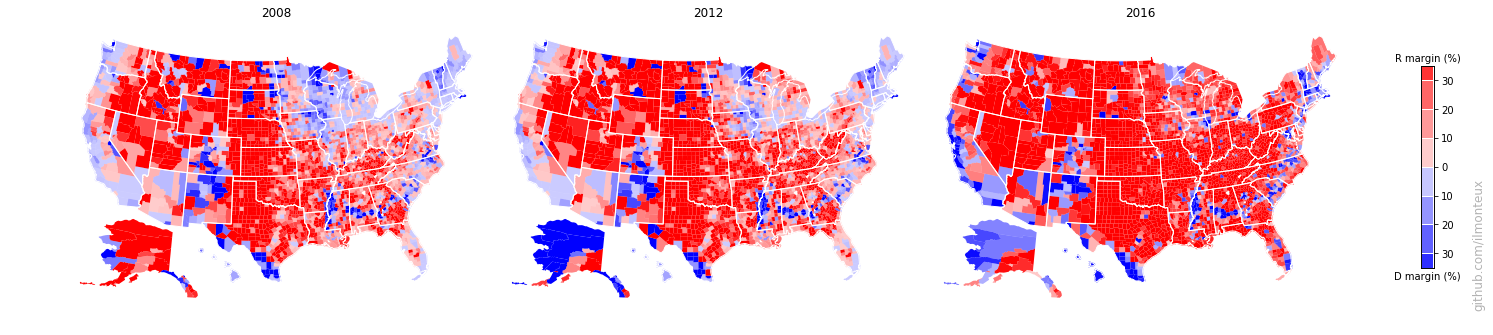

In [65]:
figc2, axes = plt.subplots(1,3,figsize=(18,4))
for idx in counties_borders.keys():
    # fill counties with color
    red = 100.*data[idx]['fields']['rep08_frac']/data[idx]['fields']['total08']
    blue = 100.*data[idx]['fields']['dem08_frac']/data[idx]['fields']['total08']
    axes[0].fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))
    
    red = 100.*data[idx]['fields']['rep12_frac']/data[idx]['fields']['total12']
    blue = 100.*data[idx]['fields']['dem12_frac']/data[idx]['fields']['total12']
    axes[1].fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))
    
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
    axes[2].fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))

for iax, ax in enumerate(axes):
    for st in cdf['STUSPS10'].tolist()+hawaii_keys:
        ax.plot(*themap(*state_border[st]), c='w',lw=1)
    ax.set_axis_off()
    ax.set_title(['2008','2012','2016'][iax])


figc2.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figc2.text(1.1, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figc2 = func_add_legend(figc2, width=0.01);

In [153]:
figc0.savefig('figs/election_county_map16.png', bbox_inches='tight',dpi=120)
figc1.savefig('figs/election_county_map16_rounded.png', bbox_inches='tight',dpi=120)
figc2.savefig('figs/election_county_map081216.png', bbox_inches='tight',dpi=120)

## county-level cartogram
[link to the top](#Index)

For making a county-level map, I have to find the area of each county, which is not in the dataset. Taking the area of the lat-lon polygons would be wrong because it would weigh differently states at different latitudes (1 degree of long is smaller farther north).  
I can take the Albers equal area projection, which by definition preserves the spherical surface area. Luckily the standard US projection, `epsg=2163`, already is an equal area projection, so I will use that

In [44]:
county_density = {}
for idx in counties_borders.keys():
    projected_poly = np.array(themap(*np.array(counties_borders[idx]).T)).T
    county_density[idx] = 1609.34**2 * data[idx]['fields']['total_population'] / Polygon(projected_poly).area

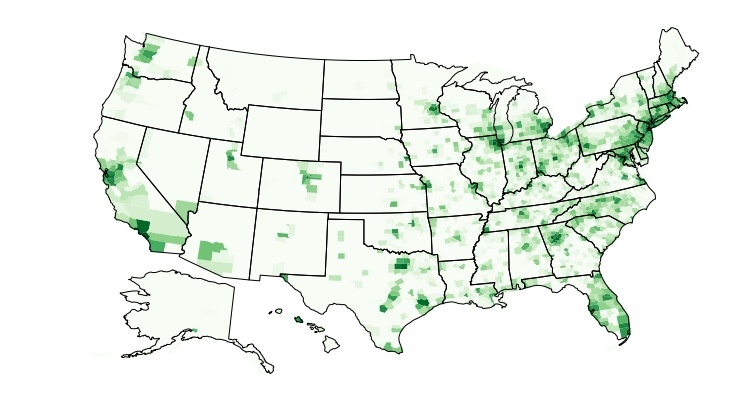

In [67]:
figd0, ax = plt.subplots(1,1,figsize=(12,7))
for idx in counties_borders.keys():
    # fill counties with color
    ax.fill(*themap(*np.array(counties_borders[idx]).T),
              facecolor=plt.get_cmap('Greens')( np.log10(np.sqrt(county_density[idx]))-0.8))

for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    ax.plot(*themap(*state_border[st]), c='k',lw=1)

ax.set_axis_off();

In [45]:
idx_by_state = {}
for st in states_short:
    idx_by_state[st] = [idx for idx in counties_borders.keys() if data[idx]['fields']['st']==st]

In [69]:
print min([min(np.array(counties_borders[idx]).T[0]) for idx in counties_borders.keys()]), max([max(np.array(counties_borders[idx]).T[0]) for idx in counties_borders.keys()])
print min([min(np.array(counties_borders[idx]).T[1]) for idx in counties_borders.keys()]), max([max(np.array(counties_borders[idx]).T[1]) for idx in counties_borders.keys()])


-124.8489739998 -66.8854439998
23.676311239824 49.3843580002


In [46]:
cartogrid2=[]
for y in np.linspace(22,51,291):
    cartogrid2.append( [[x,y] for x in np.linspace(-127,-66,611)])

For each point on this grid, we compare against all other the counties to see which county is the point in. To waste less time, we first identify the state in which it's in (first compare to 50 states and then only to the counties inside that state) to speed up.

In [47]:
# def find_in_county(latlon, state=0):
#     """Given a (lat,lon) pair, find the county that it is inside. To speed up the computation, 
#     we first find the state and then only look at the counties inside of that state"""
#     point = point_from_lat_lon(latlon)
#     st = find_in_state(latlon) if state==0 else [state]
#     if len(st)>0:
#         for idx in idx_by_state[st[0]]:
#             flag_found = Polygon(counties_borders[idx]).contains(point)
#             if flag_found: return [idx] # cut loop short
#         # deals with small differences between state border and county border
#         if state==0 and not flag_found:
#             for idx in counties_borders.keys():
#                 flag_found = Polygon(counties_borders[idx]).contains(point)
#                 if flag_found: return [idx] # cut loop short
#         if not flag_found: return [] # give up, set to average background value
#     else: return []
def find_in_county(yx, state=0, projection=False):
    """Given a latlon pair or (y,x) projected coordinates pair, find the county that it is inside. To speed up the computation, 
    we first find the state and then only look at the counties inside of that state"""
    point = Point(yx[0],yx[1]) if projection else point_from_lat_lon(yx) 
    st = find_in_state(yx) if state==0 else [state]
    if len(st)>0:
        for idx in idx_by_state[st[0]]:
            projbor = counties_borders[idx] if not projection else np.array(themap(*np.array(counties_borders[idx]).T)).T
            flag_found = Polygon(projbor).contains(point)
            if flag_found: return [idx] # cut loop short
        # deals with small differences between state border and county border
        if state==0 and not flag_found:
            for idx in counties_borders.keys():
                flag_found = Polygon(counties_borders[idx]).contains(point)
                if flag_found: return [idx] # cut loop short
        if not flag_found: return [] # give up, set to average background value
    else: return []

Aside: there are rare cases where the grid point falls inside a state but outside any county in that state (that's because the state borders are coarser than the individual county borders). For example see the following example for North Dakota (because of a river). It thinks the red point is in ND, but the more precise border shows it's in MN

[u'Pembina County, North Dakota', u'Kittson County, Minnesota', u'Kittson County, Minnesota']


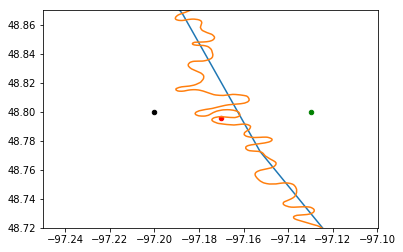

In [72]:
print map(lambda x: data[find_in_county(x)[0]]['fields']['county'],[(48.8,-97.2),(48.796,-97.17),(48.8,-97.13)])
plt.plot(*np.array(state_border['ND'])), plt.plot(*np.array(counties_borders[2397]).T)
for ipp in range(3):
    plt.scatter(*[(-97.2,48.8),(-97.17,48.796),(-97.13,48.8)][ipp],s=20,c=['k','r','g'][ipp])
plt.xlim(-97.25,-97.1),plt.ylim(48.72,48.87);

In [48]:
avg_density_proj = (1609.34**2 * sum([data[idx]['fields']['total_population'] for idx in counties_borders.keys()])/
                    sum([ Polygon(np.array(themap(*np.array(counties_borders[idx]).T)).T).area for idx in counties_borders.keys()]))

def parallel_density(ii, line, state=0, avg_density = avg_density_proj, projection=False):
    outline = []
    for jj,pp in enumerate(line):
        pp = (pp[1],pp[0]) if projection==False else (pp[0],pp[1]) 
        idx_county = find_in_county((pp[0],pp[1]), state, projection ) 
        if len(idx_county)==0: 
            density = avg_density
        else:
            projected_poly = np.array(themap(*np.array(counties_borders[idx_county[0]]).T)).T
            density = 1609.34**2 * data[idx_county[0]]['fields']['total_population'] / Polygon(projected_poly).area
        outline.append(density)
    return (ii,outline)

This next step takes a while: 611\*291 points in the grid, for each of one find which of the 3100 counties it is in. Parallelized with `joblib`.   
On my laptop, using 6 parallel jobs brings the best improvement while almost saturating the CPU

In [ ]:
%%time
tmp = Parallel(n_jobs=6)(delayed(parallel_density)(ii,line) for ii,line in enumerate(cartogrid2))

In [45]:
densitygrid_county = [t[1] for t in sorted(tmp)]

In [46]:
cx_county, cy_county = run_cart(densitygrid_county, 'us_pop_county.dat')

In [883]:
%%time 

morphed_border_county={}
for idx in counties_borders.keys():
    morphed_border_county[idx] =  np.array([ interp_cartogram(cartogrid2, cx_county, cy_county, [bb[0], bb[1]]) for bb in counties_borders[idx]])
morphed_border_st_county={}
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    morphed_border_st_county[st] = np.array([ interp_cartogram(cartogrid2, cx_county, cy_county, [bb[0], bb[1]]) for bb in np.array(state_border[st]).T ])

CPU times: user 3min 41s, sys: 9.11 s, total: 3min 50s
Wall time: 3min 58s


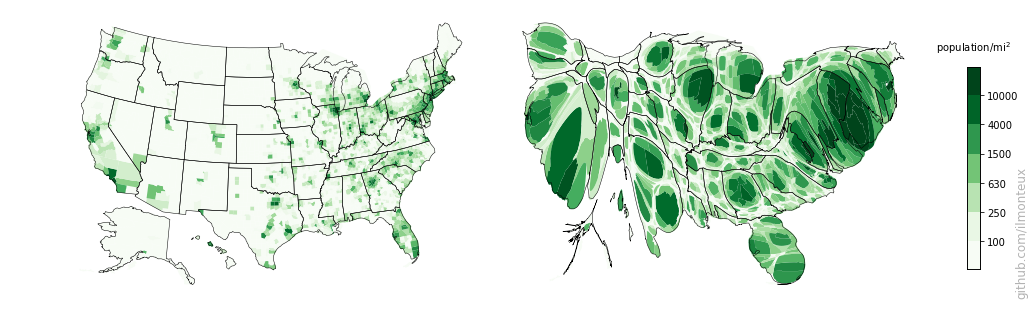

In [884]:
figdc, axes = plt.subplots(1,2,figsize=(12,4))
for idx in counties_borders.keys():
    axes[0].fill(*themap(*np.array(counties_borders[idx]).T),
              facecolor=plt.get_cmap('Greens')( np.log10(np.sqrt(county_density[idx]))-0.8))
    axes[1].fill(*np.array(morphed_border_county[idx]).T,
              facecolor=plt.get_cmap('Greens')( np.log10(np.sqrt(county_density[idx]))-0.8))
    
for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    axes[0].plot(*themap(*state_border[st]), lw=0.5, c='k')
    axes[1].plot(*np.array(morphed_border_st_county[st]).T, c='k',lw=0.5)
for ax in axes: _=ax.set_axis_off()

figdc.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
if wm: figdc.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
# add population density legend
cax = figdc.add_axes([1.05, 0.1, 0.015, 0.7])
dd=0.2
for cc in np.arange(0-dd/2,1.+dd,dd):
    cax.fill((0,0,1,1),(cc-dd/2,cc+dd/2,cc+dd/2,cc-dd/2),facecolor=plt.get_cmap('Greens')(cc))
cax.yaxis.tick_right()
cax.set_yticklabels(map(str,[40, 100, 250, 630, 1500, 4000, 10000]))
ax2=cax.twiny()    
cax.set_xticks([]), ax2.set_xticks([])
cax.set_ylim([-0.19,1.19])
ax2.set_xlabel('population/mi$^2$\n');

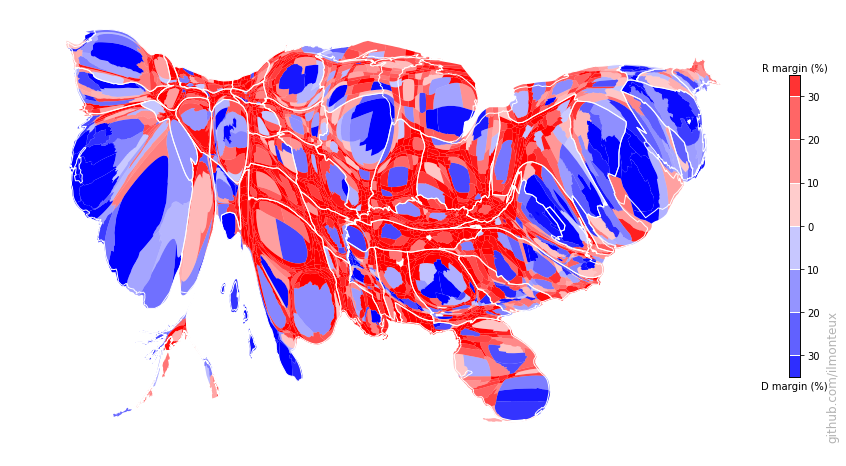

In [155]:
figcc0, ax = plt.subplots(1,1,figsize=(10,6))
for idx in counties_borders.keys()[:]:
    # fill counties with color
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
    ax.fill(*np.array(morphed_border_county[idx]).T, facecolor=col_alpha_rescale(blue, red))

for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    ax.plot(*np.array(morphed_border_st_county[st]).T, c='w',lw=1)

ax.set_axis_off()

figcc0.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figcc0.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figcc0 = func_add_legend(figcc0, width=0.015);

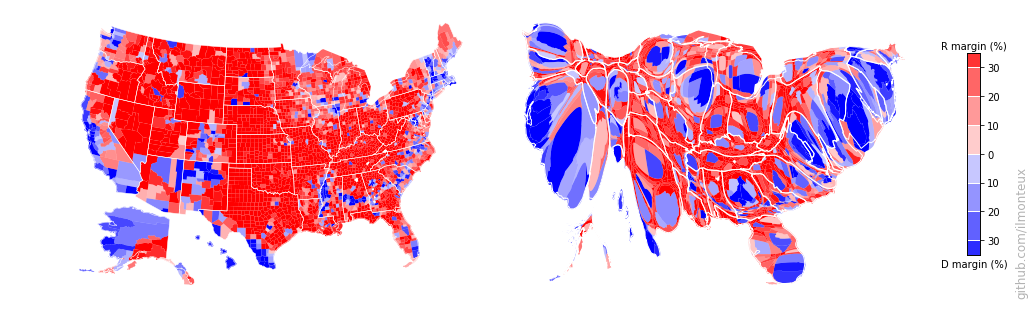

In [156]:
figcc1, axes = plt.subplots(1,2,figsize=(12,4))
for idx in counties_borders.keys():
    # fill counties with color
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
    axes[0].fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))
    axes[1].fill(*np.array(morphed_border_county[idx]).T, facecolor=col_alpha_rescale(blue, red))

for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    axes[0].plot(*themap(*state_border[st]), lw=0.5, c='w')
    axes[1].plot(*np.array(morphed_border_st_county[st]).T, c='w',lw=1)

for ax in axes: ax.set_axis_off()

figcc1.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
if wm: figcc1.text(1.12, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figcc1 = func_add_legend(figcc1, width=0.015);

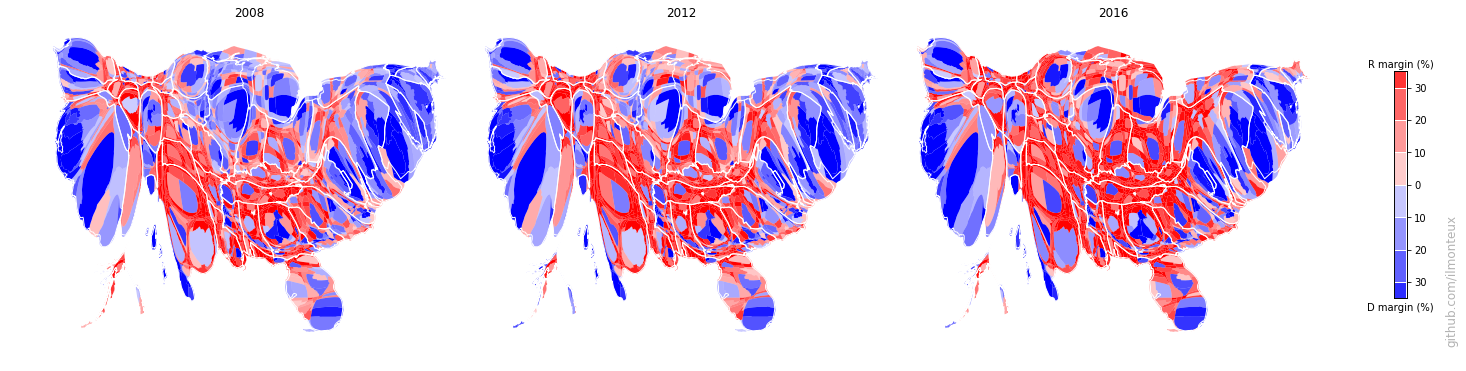

In [160]:
figcc2, axes = plt.subplots(1,3,figsize=(18,4.5))
for idx in counties_borders.keys():
    # fill counties with color
    red = 1.*data[idx]['fields']['rep08_frac']/100
    blue = 1.*data[idx]['fields']['dem08_frac']/100
    axes[0].fill(*np.array(morphed_border_county[idx]).T, facecolor=col_alpha_rescale(blue, red))
    red = 1.*data[idx]['fields']['rep12_frac']/100
    blue = 1.*data[idx]['fields']['dem12_frac']/100
    axes[1].fill(*np.array(morphed_border_county[idx]).T, facecolor=col_alpha_rescale(blue, red))
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
    axes[2].fill(*np.array(morphed_border_county[idx]).T, facecolor=col_alpha_rescale(blue, red))

for st in cdf['STUSPS10'].tolist()+hawaii_keys+['AK']:
    for ax in axes: _=ax.plot(*np.array(morphed_border_st_county[st]).T, c='w',lw=1)

for ix,ax in enumerate(axes):
    ax.set_axis_off()
    ax.set_title(['2008','2012','2016'][ix])

figcc2.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
if wm: figcc2.text(1.1, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
figcc2 = func_add_legend(figcc2, width=0.01);

In [158]:
figdc.savefig('figs/density_map_carto.png', bbox_inches='tight',dpi=120)

In [159]:
figcc0.savefig('figs/election_county_carto16.png', bbox_inches='tight',dpi=120)
figcc1.savefig('figs/election_county_map_carto.png', bbox_inches='tight',dpi=120)
figcc2.savefig('figs/election_county_carto081216.png', bbox_inches='tight',dpi=120)

# state level cartogram, with highways
[link to the top](#Index)

In the US-wide maps above, details for each state are mostly too small to discern. I can take each state individually and make a population cartogram that will show the internal shifting of counties. To make maps more recognizable, I also add interstate highways (US census TIGER dataset - http://www2.census.gov/geo/tiger/TIGER2016/PRIMARYROADS/tl_2016_us_primaryroads.zip )

In [63]:
idf = gpd.GeoDataFrame.from_file(os.path.join('input','tl_2016_us_primaryroads.dbf'))
idf.head()
# idf[idf['RTTYP']=='I'].head() # only pick up interstates

LINEARID          FULLNAME RTTYP  MTFCC  \
0  1105647111403  Morgan Branch Dr     M  S1100   
1  1103662626368       Biddle Pike     M  S1100   
2  1103662626717   Cincinnati Pike     M  S1100   
3  1105056901124            I- 405     I  S1100   
4  1105056901128            I- 405     I  S1100   

                                            geometry  
0  LINESTRING (-75.61562299999999 38.625174, -75....  
1  LINESTRING (-84.56701699999999 38.360526, -84....  
2  LINESTRING (-84.568051 38.348926, -84.56800899...  
3  LINESTRING (-122.679601 45.54082199999999, -12...  
4  LINESTRING (-122.670959 45.506849, -122.671025...

Create dictionary of interstates by state.

In [64]:
%%time

idic = {}
for st in cdf['STUSPS10'].tolist():
    print st, 
    x_range = map(lambda f: f(state_border[st][0]),[min,max])
    y_range = map(lambda f: f(state_border[st][1]),[min,max])
    idic[st] = []
    for i, intst in idf[idf['RTTYP']=='I'].iterrows(): # only pick interstates
        tmp = list(intst['geometry'].coords)
        # will only check segments that are within the state
        if all([x_range[0]<tmp[0][0]<x_range[1], x_range[0]<tmp[-1][0]<x_range[1], y_range[0]<tmp[0][1]<y_range[1], y_range[0]<tmp[-1][1]<y_range[1]]):
            if Polygon(np.array(state_border[st]).T).contains(Point(*tmp[len(tmp)/2])):
                idic[st].append([intst['FULLNAME'], tmp])

AL AZ AR CA CO CT DE DC FL GA ID IL IN IA KS KY LA ME MD MA MI MN MS MO MT NE NV NH NJ NM NY NC ND OH OK OR PA RI SC SD TN TX UT VT VA WA WV WI WYCPU times: user 3min 52s, sys: 123 ms, total: 3min 52s
Wall time: 3min 52s



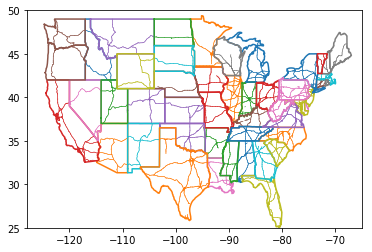

In [65]:
for ist, st in enumerate(cdf['STUSPS10'].tolist()):
    _=plt.plot(*state_border[st])
    for name, road in idic[st]:
        _=plt.plot(*np.array(road).T,c=plt.get_cmap("tab10")(ist%10),lw=0.5)
_ = plt.xlim(-128,-65), plt.ylim(25,50)

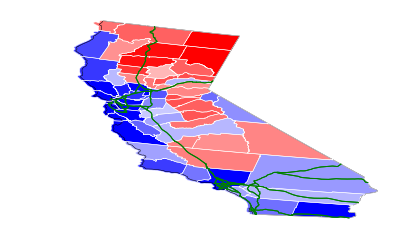

In [66]:
fig,ax = plt.subplots()

st = 'CA'
_=ax.plot(*themap(*state_border[st]), lw=0.5, c='k')
for idx in idx_by_state[st]:
    red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
    blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']

    _=plt.plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='w')
    _=plt.fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))
for name, road in idic[st]:
    _=plt.plot(*themap(*np.array(road).T),c='g',lw=1)
plt.axis('off');

In [64]:
%%time 
cxst, cyst = {}, {}
cartogridst={}
densitygrid_st={}
figst={}

state_list = [st for st in cdf['STUSPS10'].tolist() if st!='DC']+['AK']
for st in state_list:
    print st,
    cartogridst[st]=[]
    x_range = (lambda (m,M): (m-0.15*(M-m), M+0.15*(M-m)))(map( lambda f : f(themap(*state_border[st])[0]),[min,max]))
    y_range = (lambda (m,M): (m-0.15*(M-m), M+0.15*(M-m)))(map( lambda f : f(themap(*state_border[st])[1]),[min,max]))
    if st=='AK': x_range = (0.9*x_range[0],x_range[1]) # make more space for outlying islands
    for y in np.linspace(*y_range,num=60):
        cartogridst[st].append( [[x,y] for x in np.linspace(*x_range,num=60)])
    
    avg_density_st = (1609.34**2 * sum([data[idx]['fields']['total_population'] for idx in idx_by_state[st]])/
                    sum([ Polygon(np.array(themap(*np.array(counties_borders[idx]).T)).T).area for idx in idx_by_state[st]]))

    tmp = Parallel(n_jobs=6)(delayed(parallel_density)(ii,line, st, avg_density_st, True) for ii,line in enumerate(cartogridst[st]))
    densitygrid_st[st] = [t[1] for t in sorted(tmp)]
    cxst[st], cyst[st] = run_cart(densitygrid_st[st], 'us_pop_county_'+st+'.dat')

AL AZ AR CA CO CT DE FL GA ID IL IN IA KS KY LA ME MD MA MI MN MS MO MT NE NV NH NJ NM NY NC ND OH OK OR PA RI SC SD TN TX UT VT VA WA WV WI WY AKCPU times: user 1min 39s, sys: 3min 41s, total: 5min 20s
Wall time: 1h 19min 4s



In [166]:
%%capture

titles = ['2016 election','population density','cartogram']
for st in state_list:
    figst[st], axes = plt.subplots(1,3,figsize=(10,3))
    for idx in idx_by_state[st]:
        red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
        blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']

        _=axes[0].plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='w')
        _=axes[0].fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))

        _=axes[1].plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='0.5')
        _=axes[1].fill(*themap(*np.array(counties_borders[idx]).T),
              facecolor=plt.get_cmap('Greens')( np.log10(np.sqrt(county_density[idx]))-0.8))

        sbo = np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in counties_borders[idx]])
        _=axes[2].plot(*sbo.T, lw=0.5, c='w')
        _=axes[2].fill(*sbo.T, facecolor=col_alpha_rescale(blue, red))
    _=axes[0].plot(*themap(*state_border[st]), lw=1, c='k')
    _=axes[1].plot(*themap(*state_border[st]), lw=1, c='k')
    _=axes[2].plot(*np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in np.array(state_border[st]).T]).T, lw=1, c='k')
    for iax,ax in enumerate(axes):
        _=ax.set_axis_off()
        _=ax.set_title(state_short_to_long[st]+' '+titles[iax])
    if st!='AK':
        for name, road in idic[st]:
            _=axes[0].plot(*themap(*np.array(road).T),c='g',lw=0.75)
            _=axes[1].plot(*themap(*np.array(road).T),c='b',lw=0.5)
            _=axes[2].plot(*np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in road]).T, lw=0.75, c='g')
    figst[st].subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
    if wm: figst[st].text(1.125, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
    figst[st] = func_add_legend(figst[st], width=0.015);

In [167]:
for st in state_list:
    figst[st].savefig('figs/state_maps/election_county_16_'+st+'.png', bbox_inches='tight',dpi=120)

Plot all states next to each other

In [73]:
from matplotlib.lines import Line2D
from matplotlib.transforms import blended_transform_factory

def add_separators(figgrid, axes):
    lines= []
    for irow in range(len(axes)-1):
        trans = blended_transform_factory(figgrid.transFigure, axes[irow][0].transAxes)
        lines.append(Line2D([0.12,0.92], [-0.05, -0.05], color='0.5', transform=trans))
    for icol in range(len(axes[0])/3-1):
        trans = blended_transform_factory(axes[0][3*icol+3].transAxes, figgrid.transFigure)
        lines.append(Line2D([-0.05,-0.05], [0.1, 0.9], color='0.5', transform=trans))
    return lines


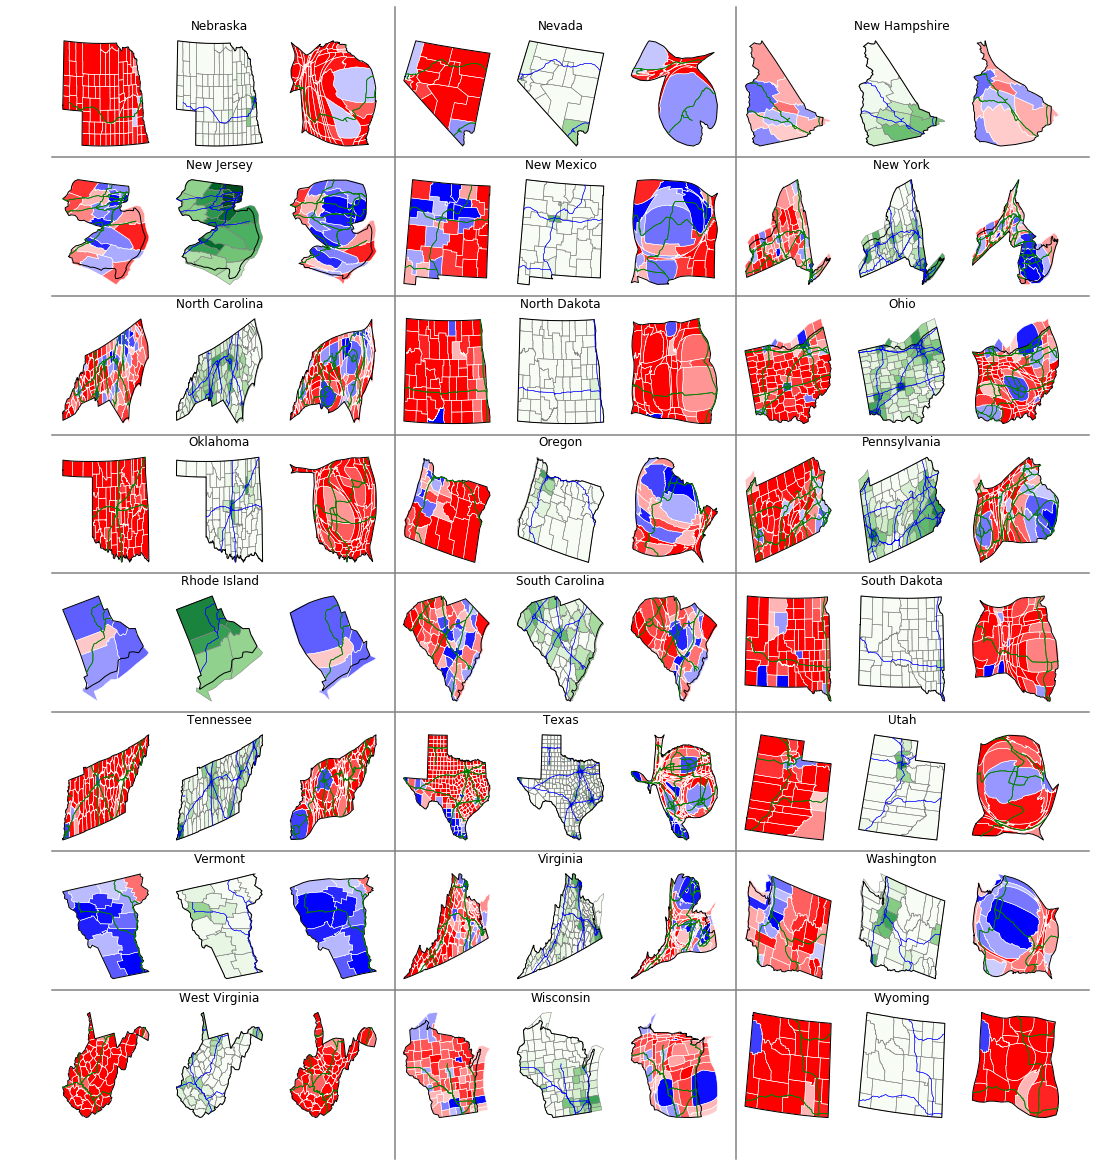

In [77]:
# do_states = state_list[:24]
do_states = state_list[24:-1]
figgrid, axes = plt.subplots(len(state_list[24:])/3,3*3, figsize=(18,20))

for ist, st in enumerate(do_states):
    icol, irow = ist%(len(axes[0])/3), (ist - ist%(len(axes[0])/3))/(len(axes[0])/3)
    for idx in idx_by_state[st]:
        red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
        blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']

        axes[irow][3*icol].plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='w')
        axes[irow][3*icol].fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))

        axes[irow][3*icol+1].plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='0.5')
        axes[irow][3*icol+1].fill(*themap(*np.array(counties_borders[idx]).T),
              facecolor=plt.get_cmap('Greens')( np.log10(np.sqrt(county_density[idx]))-0.8))

        sbo = np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in counties_borders[idx]])
        axes[irow][3*icol+2].plot(*sbo.T, lw=0.5, c='w')
        axes[irow][3*icol+2].fill(*sbo.T, facecolor=col_alpha_rescale(blue, red))
    axes[irow][3*icol].plot(*themap(*state_border[st]), lw=1, c='k')
    axes[irow][3*icol+1].plot(*themap(*state_border[st]), lw=1, c='k')
    axes[irow][3*icol+2].plot(*np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in np.array(state_border[st]).T]).T, lw=1, c='k')
    axes[irow][3*icol+1].set_title(state_short_to_long[st])
    for name, road in idic[st]:
        _=axes[irow][3*icol].plot(*themap(*np.array(road).T),c='g',lw=0.75)
        _=axes[irow][3*icol+1].plot(*themap(*np.array(road).T),c='b',lw=0.5)
        _=axes[irow][3*icol+2].plot(*np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in road]).T, lw=0.75, c='g')
    for axrow in axes:
        for ax in axrow: ax.set_axis_off()
figgrid.lines = add_separators(figgrid, axes);

In [76]:
figgrid.savefig('figs/state_maps/states_county_16_all_grid1.png', bbox_inches='tight',dpi=120)

In [78]:
figgrid.savefig('figs/state_maps/states_county_16_all_grid2.png', bbox_inches='tight',dpi=120)

In [103]:
from matplotlib.lines import Line2D
from matplotlib.transforms import blended_transform_factory

def add_separators(figgrid, axes):
    lines= []
    for irow in range(0,len(axes)-1,9):
        trans = blended_transform_factory(figgrid.transFigure, axes[irow].transAxes)
        lines.append(Line2D([0.12,0.92], [-0.05, -0.05], color='0.5', transform=trans))
    for icol in range(3,9-1,3):
        trans = blended_transform_factory(axes[icol].transAxes, figgrid.transFigure)
        lines.append(Line2D([-0.05,-0.05], [0.1, 0.9], color='0.5', transform=trans))
    return lines


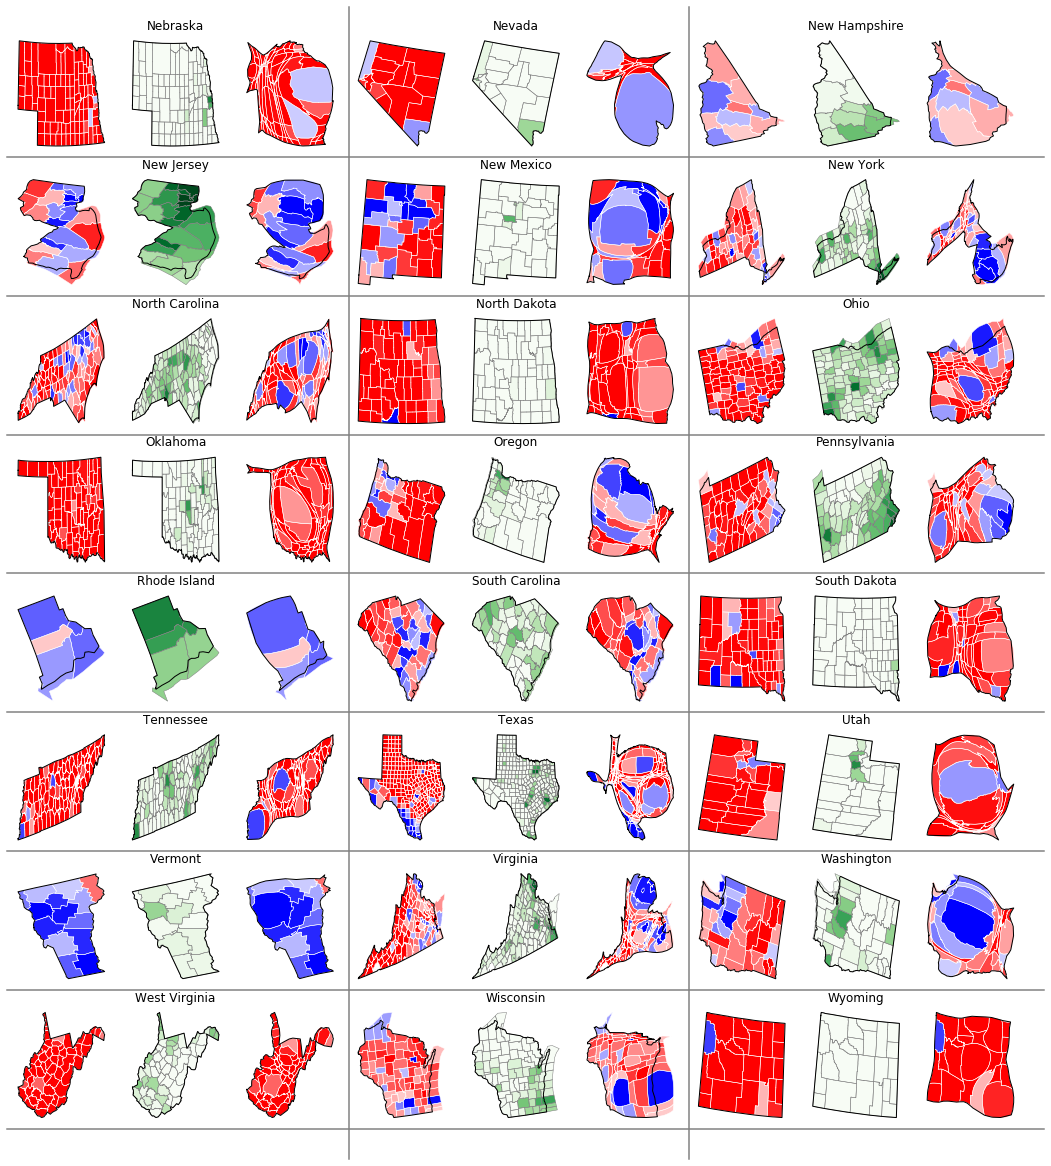

In [104]:
# do_states = state_list[:24]
do_states = state_list[24:-1]
import matplotlib.gridspec as gridspec

figgrid = plt.figure(figsize=(18,20))
outer_grid = gridspec.GridSpec(len(do_states)/3,3, wspace=0.05, hspace=0.2)

for ist,st in enumerate(do_states):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_grid[ist])
    ax1 = plt.Subplot(figgrid, inner_grid[0])
    ax2 = plt.Subplot(figgrid, inner_grid[1])
    ax3 = plt.Subplot(figgrid, inner_grid[2])
    for idx in idx_by_state[st]:
        red = 1.*data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes']
        blue = 1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes']
        ax1.plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='w')
        ax1.fill(*themap(*np.array(counties_borders[idx]).T), facecolor=col_alpha_rescale(blue, red))

        ax2.plot(*themap(*np.array(counties_borders[idx]).T), lw=0.5, c='0.5')
        ax2.fill(*themap(*np.array(counties_borders[idx]).T), facecolor=plt.get_cmap('Greens')( np.log10(np.sqrt(county_density[idx]))-0.8))

        sbo = np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in counties_borders[idx]])
        _=ax3.plot(*sbo.T, lw=0.5, c='w')
        _=ax3.fill(*sbo.T, facecolor=col_alpha_rescale(blue, red))
    ax1.plot(*themap(*state_border[st]), lw=1, c='k')
    ax2.plot(*themap(*state_border[st]), lw=1, c='k')
    ax3.plot(*np.array([ interp_cartogram(cartogridst[st], cxst[st], cyst[st], themap(bb[0], bb[1])) for bb in np.array(state_border[st]).T]).T, lw=1, c='k')
    ax2.set_title(state_short_to_long[st])
    for ax in [ax1,ax2,ax3]:
        ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        figgrid.add_subplot(ax);

all_axes = figgrid.get_axes()

figgrid.lines = add_separators(figgrid, all_axes);